In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [2]:
root_dir = Path().cwd().parent
interim_dir = root_dir / 'data/interim'
undistorted_dir = interim_dir / 'undistorted'
rectified_dir = interim_dir / 'rectified'
rectified_dir.mkdir(parents=True, exist_ok=True)

In [3]:
def rectifyImages(img1, img2, nb_matches=200):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    pts1 = []
    pts2 = []
    for m in matches[:nb_matches]:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1, confidence=0.95)
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    ret, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=img1_gray.shape)
    if ret:
        img1_rect = cv2.warpPerspective(img1, H1, (img1_gray.shape[1], img1_gray.shape[0]))
        img2_rect = cv2.warpPerspective(img2, H2, (img2_gray.shape[1], img2_gray.shape[0]))
        return img1_rect, img2_rect
    else:
        return None, None

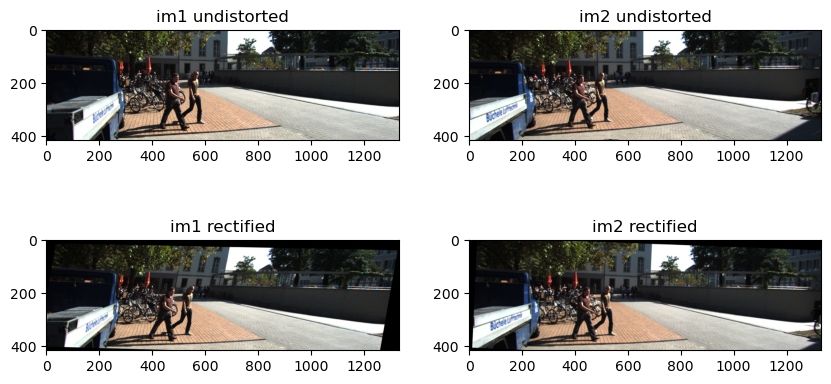

In [5]:
folders = os.listdir(root_dir / 'data/interim/undistorted/seq_01')
images = os.listdir(root_dir / 'data/interim/undistorted/seq_01' / folders[0])[:1]

for k, image in enumerate(images):
    im1 = cv2.imread(str(root_dir / 'data/interim/undistorted/seq_01' / folders[0] / image))
    im2 = cv2.imread(str(root_dir / 'data/interim/undistorted/seq_01' / folders[1] / image))

    im1_rect, im2_rect = rectifyImages(im1, im2)

    if (k == 0):
        fig, axs = plt.subplots(2, 2, figsize=(10,5))
        axs[0, 0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title('im1 undistorted')
        axs[0, 1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        axs[0, 1].set_title('im2 undistorted')
        axs[1, 0].imshow(cv2.cvtColor(im1_rect, cv2.COLOR_BGR2RGB))
        axs[1, 0].set_title('im1 rectified')
        axs[1, 1].imshow(cv2.cvtColor(im2_rect, cv2.COLOR_BGR2RGB))
        axs[1, 1].set_title('im2 rectified')

In [43]:
import numpy as np
def Fest(points1, points2):
    B = np.asarray([])
    for x1i,y1i,x2i,y2i in zip(points1[0][1:],points1[1][1:],points2[0][1:],points2[1][1:]):
        Bi = np.asarray([x1i*x2i,x1i*y2i,x1i,y1i*x2i,y1i*y2i,y1i,x2i,y2i,1])
        if B.shape[0] == 0: B = Bi
        else: B = np.vstack((B, Bi))
    _, _, v = np.linalg.svd(B, full_matrices=True)
    FTf = v[-1]
    F = FTf.reshape(3,3).T
    return F

In [33]:
import cv2
image1 = cv2.imread('../data/raw/final_project/calib/image_02/data/0000000000.png')
image2 = cv2.imread('../data/raw/final_project/calib/image_03/data/0000000000.png')

%matplotlib tk
from matplotlib import pyplot as plt
plt.rcParams['backend'] = 'TkAgg'
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

coords1 = []
def onclick1(event):
   coords1.append([event.xdata, event.ydata])
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY))
fig.canvas.mpl_connect('button_press_event', onclick1)
plt.show()

coords2 = []
def onclick2(event):
   coords2.append([event.xdata, event.ydata])
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY))
fig.canvas.mpl_connect('button_press_event', onclick2)
plt.show()

In [42]:
coords1 = np.asarray(coords1)[1:].T
coords2 = np.asarray(coords2)[1:].T

[[None 169.15445604061222 180.14098037807452 194.15827005000926
  207.41786838832587 220.2986210598334 232.04283673091385
  243.40820673518527 253.25819407222048 264.62356407649185
  274.85239708033606 285.08123008418033 167.26022770656698
  179.7621347112655 192.26404171596403 207.41786838832587
  218.78323839259724 230.52745406367768 241.13513273433097
  254.77357673945664 263.86587274287376 274.85239708033606
  285.08123008418033 165.74484503933076 180.89867171169266
  194.53711571681828 204.38710305385348 218.40439272578817
  230.52745406367768 241.13513273433097 252.50050273860234
  263.4870270760647 273.71586007990896 285.4600757509894
  164.98715370571267 177.86790637722027 192.26404171596403
  205.9024857210897 216.13131872493392 228.63322572963244
  241.13513273433097 251.74281140498425 262.7293357424466
  273.3370144130999 284.32353875056225 527.1636111751609
  544.5905118483771 562.3962581884023 578.6866218611913 595.7346768675983
  613.1615775408144 629.8307868804125 528.67

In [44]:
F = Fest(coords1, coords2)
print(F)

[[-4.88275429e-07  2.05849860e-05 -6.64018295e-03]
 [-2.12782599e-05 -1.02457104e-06  1.51626924e-02]
 [ 7.40423539e-03 -1.21738641e-02 -9.99761459e-01]]


In [50]:
ret, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(coords1.T[1:]), np.float32(coords2.T[1:]), F, imgSize=image1.shape[:2])
image1_rect = cv2.warpPerspective(image1, H1, (image1.shape[1], image1.shape[0]))
image2_rect = cv2.warpPerspective(image2, H2, (image2.shape[1], image2.shape[0]))

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs[0, 0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('im1')
axs[0, 1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('im2')
axs[1, 0].imshow(cv2.cvtColor(image1_rect, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('im1 rectified')
axs[1, 1].imshow(cv2.cvtColor(image2_rect, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('im2 rectified')

Text(0.5, 1.0, 'im2 rectified')